Use Scikit-Learn to generate two circles with different colored dots

In [1]:
from sklearn.datasets import make_circles

In [2]:
samples = 1000
X, y = make_circles(samples,
                    noise = 0.05,
                    random_state=53)

In [3]:
print("The features X are:", X[:5])

The features X are: [[-0.73605009  0.27724083]
 [ 0.59796838  0.47581336]
 [-0.49658813  0.57528068]
 [ 0.36392779 -0.74964111]
 [ 0.375238    1.02743359]]


In [4]:
print("The labels y are: ", y[:5])

The labels y are:  [1 1 1 1 0]


PLOT THE CIRCLES

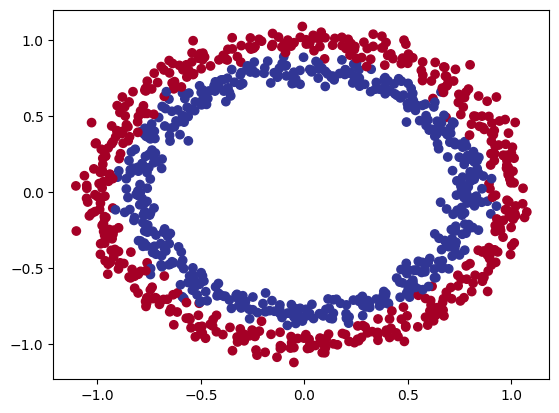

In [5]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

CONVERT NUMPY ARRAYS INTO TENSORS FOR CLASSIFICATION

In [6]:
import torch


In [7]:
#X = torch.from_numpy(X)
#y = torch.from_numpy(y)
#X[:10]
#y[:10]

SPLIT THE TENSORS INTO TEST AND TRAINING DATASET

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=54)

In [9]:
len(X_train), len(y_train), len(X_test)

(800, 800, 200)

After creating our data, we build our own model
- Check if system uses cuda or cpu
- We use nn.Linear instead of nn.Parameter here

In [10]:
import torch
from torch import nn

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

1. nn.Module for the main class
2. nn.Linear to make use of parameters
3. forward() function to compute the build model

Linear creates two layers:
- the first takes two features as input and gives 5 out features as input to second layer
- the second layer takes previous output as input and gives as output 1 feature
- the 5 features in the middle of input and output are the hidden units or nuerons (better output by learning extra features)
- Instead of nn.Linear we can also use nn.Sequential (more straightforward but runs sequentially)

In [12]:
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))

model = CircleModel().to(device)
model

CircleModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

We pass in our initial data into our built model

In [19]:
#untrained_preds = model(X_test.to(device))
#untrained_preds[:10]



In [16]:
y_test[:10]

array([1, 0, 1, 0, 1, 1, 1, 0, 1, 0])

TO MAKE BETTER PREDICTIONS OF THE MODEL, WE NOW USE CREATE LOSS FUNCTIONS AND OPTIMIZERS
- LOSS FUNCTION (BINARY CROSS ENTROPY)
   - BCELOSS
   - BCEWithLogitsLoss (uses sigmoid layer for stability)

- OPTIMIZER (SGD)

In [17]:
loss_fn = nn.BCEWithLogitsLoss()
optimiser = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)

CALCULATING EVALUATION METRICS (ACCURACY)

In [18]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

TRAIN THE MODEL (TRAINING LOOP)

1. LOGITS - raw, unnormalized data
2. SIGMOID - activation function to compute probablities of the logits between 0 and 1.
3. Based on the probability classification is done into class1 or class0 - for binary classification.

In [23]:
X_test_tensor = torch.tensor(X_test)
X_test_tensor[:5]

tensor([[-0.5296,  0.5373],
        [ 0.3952,  0.9862],
        [-0.5945, -0.3941],
        [-0.8774,  0.4017],
        [ 0.7296, -0.3523]], dtype=torch.float64)

In [34]:
y_logits = model(X_test_tensor.to(device).float())[:5]
y_logits

tensor([[-0.2569],
        [-0.2747],
        [-0.3133],
        [-0.2480],
        [-0.3774]], grad_fn=<SliceBackward0>)

In [35]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4361],
        [0.4317],
        [0.4223],
        [0.4383],
        [0.4068]], grad_fn=<SigmoidBackward0>)

In [36]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model(X_test_tensor.to(device).float())[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

BUILDING TRAINING AND TESTING LOOP

TRAINING LOOP

In [51]:
torch.manual_seed(42)
epochs = 100

X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)
X_train_tensor, y_train_tensor = X_train_tensor.to(device), y_train_tensor.to(device)
X_test_tensor, y_test_tensor= X_test_tensor.to(device), y_test_tensor.to(device)

for epoch in range(epochs):
  model.train()

  #forward pass
  X_train_tensor = X_train_tensor.to(torch.float32)  # Convert to float32
  y_logits = model(X_train_tensor).squeeze()  # Forward pass


  #calculate loss function
  y_train_tensor = y_train_tensor.to(torch.float32)  # Convert labels to int64
  loss = loss_fn(y_logits, y_train_tensor)

  #optimizer
  optimiser.zero_grad()

  #loss backwards
  loss.backward()

  #optimizer step
  optimiser.step()


TESTING LOOP

In [60]:
model.eval()

with torch.inference_mode():

  test_logits = model(X_test_tensor.to(torch.float32))
  test_pred = torch.round(torch.sigmoid(test_logits))

  test_logits = test_logits.squeeze()
  y_test_tensor = y_test_tensor.float()  # Convert to float
  loss = loss_fn(test_logits, y_test_tensor)

  if epoch % 10 == 0:
     print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")



PLOTTING MODELS PREDICTIONS USING HELPER_FUNCTIONS OF PYTHON

In [61]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

VISUALIZE the decision boundaries of training and tets datasets

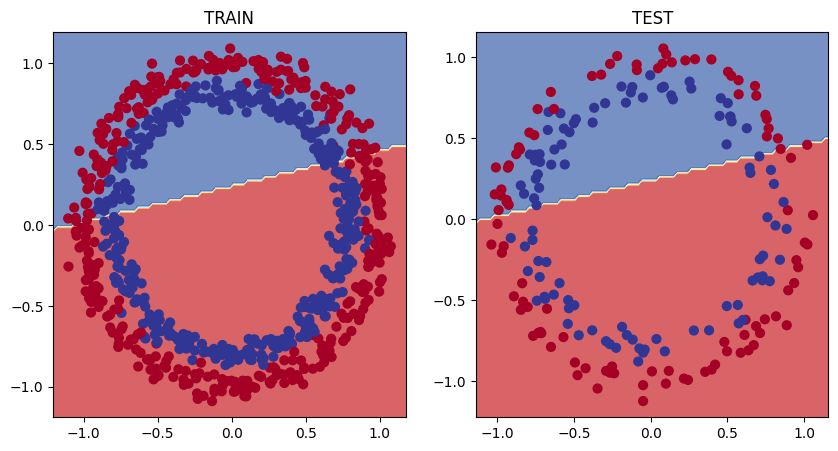

In [68]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("TRAIN")
plot_decision_boundary(model, X_train_tensor, y_train_tensor)
plt.subplot(1,2,2)
plt.title("TEST")
plot_decision_boundary(model, X_test_tensor, y_test_tensor)


model above is currently classifying the red and blue dots (classes) using a straight line, which is not the correct decision boundary for classification.

Underfitting can be fixed by changin any of the hyperparameters:
1. Add more layers
2. Add more hidden units
3. Fitting for longer (more epochs)
4. Changing the activation functions
5. Change the learning rate
6. Change the loss function
7. Use transfer learning

USE NON-LINEARITY (ReLU) actiavtion

In [69]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [70]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [95]:
# Fit the model
torch.manual_seed(42)
epochs = 1000
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)

# Put all data on target device
X_train_tensor, y_train_tensor = X_train_tensor.to(device), y_train_tensor.to(device)
X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train_tensor.to(torch.float32))
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    y_train_tensor = y_train_tensor.squeeze()
    y_train_tensor = y_train_tensor.to(torch.float32)
    y_logits = y_logits.squeeze()
    loss = loss_fn(y_logits, y_train_tensor) # BCEWithLogitsLoss calculates loss using logits

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test_tensor.to(torch.float32))
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      y_test_tensor = y_test_tensor.squeeze()
      test_logits = test_logits.squeeze()
      y_test_tensor = y_test_tensor.to(torch.float32)
      test_loss = loss_fn(test_logits, y_test_tensor)



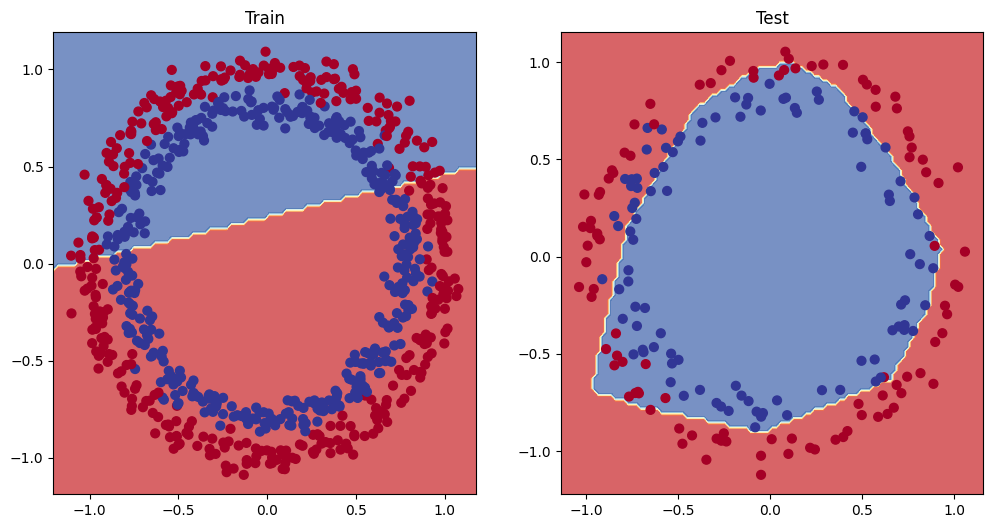

In [98]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train_tensor, y_train_tensor) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test_tensor, y_test_tensor) # model_3 = has non-linearity